<a href="https://colab.research.google.com/github/microprediction/timeseries-notebooks/blob/main/pycaret_microprediction_timemachines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret[full]
!pip install --upgrade statsmodels
!pip install microprediction
!pip install timemachines


## Leveraging Time-Machines and PyCaret together
This notebook demonstrates how you can use pycaret and timemachines packages together. We shall:

*   Grab a live time series from microprediction
*   Fit with pycaret
*   Run some timemachines models
*   Fit with pycaret again

Yup, there's a chance of overfitting ! 







### 1. Retrieve recent history of a live time series from www.microprediction.org

microprediction is "live" whereas pycaret is for "offline" analysis of time-series. Be aware:

*   Time series are live, so each time you run this the data will be different
*   Time series are returned as lagged values, so you need to reverse them for chronological ordering
*   Time is measured in epoch seconds at microprediction

A little loop to ensure the time series is long enough.



In [2]:
import microprediction
from datetime import datetime, timedelta
from microprediction import MicroReader
import random
import matplotlib.pyplot as plt
import pandas as pd

Text(0.5, 1.0, 'finance-futures-palladium-volume.json')

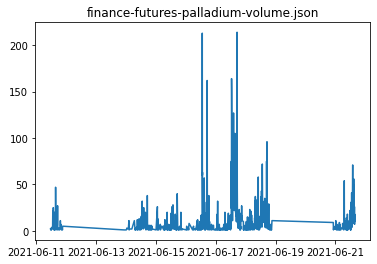

In [35]:

mr = MicroReader()
all_streams = mr.get_stream_names()
lagged_values = []
while len(lagged_values)<900:
  a_stream = random.choice(all_streams)
  lagged_values, lagged_seconds = mr.get_lagged_values_and_times(a_stream)
values = list(reversed(lagged_values))
dt = [ datetime.fromtimestamp(s) for s in reversed(lagged_seconds)] # arbitrary offset
plt.plot(dt,values)
plt.title(a_stream)

### Use Py-caret to fit a univariate time-series model
Add a few features 


In [5]:
df = pd.DataFrame(columns=['Date','y'])
df['date'] = dt
df['y']=values
df['dayofweek'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
num_lags = 10
lags = range(1,num_lags)
lag_names = [ 'y_'+str(lag) for lag in lags ]
for lag, lag_name in zip(lags,lag_names):
  df[lag_name] = df['y'].shift(lag)
numerical_features = lag_names
categorical_features =  ['dayofweek','hour']

Then fit lots of models and compare ...

In [8]:
from pycaret.regression import setup, compare_models, pull

In [9]:
s = setup(df, target = 'y', train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              ignore_features = ['date'],
              numeric_features = numerical_features,
              categorical_features = categorical_features,
              silent = True, verbose = False, session_id = 123)

In [13]:
top5 = compare_models(n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,4.721000e+00,6.166230e+01,7.526900e+00,-2.500000e-03,1.3966,1.022600e+00,0.0200
llar,Lasso Least Angle Regression,4.709400e+00,6.160580e+01,7.525700e+00,-3.300000e-03,1.5339,9.985000e-01,0.0233
lasso,Lasso Regression,4.739300e+00,6.180690e+01,7.536900e+00,-5.700000e-03,1.3020,1.049100e+00,0.0267
en,Elastic Net,4.766200e+00,6.208360e+01,7.551500e+00,-8.800000e-03,1.2228,1.081000e+00,0.0200
ada,AdaBoost Regressor,5.055000e+00,6.838070e+01,7.974200e+00,-1.437000e-01,1.1281,1.401900e+00,0.1267
omp,Orthogonal Matching Pursuit,4.932800e+00,6.395490e+01,7.801100e+00,-1.453000e-01,1.2277,1.284000e+00,0.0200
knn,K Neighbors Regressor,5.037200e+00,6.826070e+01,8.008600e+00,-1.729000e-01,1.1054,1.318000e+00,0.0867
huber,Huber Regressor,5.253500e+00,7.232880e+01,8.155800e+00,-1.946000e-01,0.9905,1.567300e+00,0.0533
catboost,CatBoost Regressor,5.215800e+00,6.979860e+01,8.132100e+00,-2.304000e-01,1.0350,1.402500e+00,1.7633
lightgbm,Light Gradient Boosting Machine,5.432000e+00,7.281760e+01,8.325300e+00,-3.007000e-01,0.9841,1.707600e+00,0.0600


## Use py-caret and timemachines together
Use timemachines to generate some more features
*   By default 3rd party time-series models are not included in timemachines install, so we manually installed statsmodels above. It should be a recent version (e.g. 0.12.2). 



In [14]:
!pip freeze | grep statsmodels

statsmodels==0.12.2


If you can't run this line, then you need to !pip install --upgrade statsmodels

In [15]:
from statsmodels.tsa.arima_model import ARIMA

Now we run a bunch of univariate time-series models over the data to create forecasts. These can be used as features in pycaret. See [timemachiens](https://github.com/microprediction/timemachines) package for more possibilities (such as Facebook prophet, neuralprophet and so forth) but be warned that some of those libraries will take a very long time to run! Even statsmodels TSA drags a bit, as you can see...

In [18]:
from timemachines.skaters.allskaters import EMA_SKATERS, DLM_SKATERS, THINKING_SKATERS, TSA_SKATERS, HYPOCRATIC_ENSEMBLE_SKATERS
from timemachines.skating import prior 
skaters = EMA_SKATERS + DLM_SKATERS + TSA_SKATERS + HYPOCRATIC_ENSEMBLE_SKATERS
skater_names = [ f.__name__ for f in skaters ]
for f, skater_name in zip(skaters,skater_names):
    print('Running '+skater_name)
    y = df['y'].values
    x,x_std = prior(f, y=y, k=1) # Runs a time-series model forward
    df[skater_name] = x 


   

Running empirical_last_value
Running sluggish_moving_average
Running slowly_moving_average
Running quickly_moving_average
Running rapidly_moving_average
Running balanced_ema_ensemble
Running aggressive_ema_ensemble
Running precision_ema_ensemble
Running tsa_p1_d0_q0
Running tsa_p2_d0_q0
Running tsa_p3_d0_q0
Running tsa_p1_d0_q1
Running tsa_p2_d0_q1
Running tsa_p3_d0_q1
Running tsa_p1_d1_q0
Running tsa_p2_d1_q0
Running tsa_p3_d1_q0
Running tsa_p1_d1_q0
Running tsa_p2_d1_q0
Running tsa_p3_d1_q0
Running quick_balanced_ema_ensemble
Running slow_balanced_ema_ensemble
Running quick_aggressive_ema_ensemble
Running slow_aggressive_ema_ensemble
Running quick_precision_ema_ensemble
Running slow_precision_ema_ensemble


Perhaps that was a little painful. That's why the timemachines library exists - to provides fast incremental time-series models (in addition to exposing others whose speed is what it is).

But now we can use the 1 step ahead forecasts as feature

In [51]:
# Skaters are supposed to return a list of foreward predictions, but we only want
# one of them so we extract the first element in the list
# Here I do this defensively as there are a couple of models that might violate this convention
for skater_name in skater_names:
  if isinstance( df[skater_name].values[0],list ):
     df[skater_name] = [ x[0] for x in df[skater_name].values]
  

In [53]:
df['quick_aggressive_ema_ensemble'].values[:4]

array([         nan,   7.5       , -21.75      ,   3.75301247])

In [54]:
s = setup(df, target = 'y', train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              ignore_features = ['date'],
              numeric_features = numerical_features + skater_names,
              categorical_features = categorical_features,
              silent = True, verbose = False, session_id = 321)
top5again = compare_models(n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,4.709400e+00,6.160580e+01,7.525700e+00,-3.300000e-03,1.5339,9.985000e-01,0.0200
lasso,Lasso Regression,4.740300e+00,6.207160e+01,7.556500e+00,-1.180000e-02,1.2758,1.072000e+00,0.0200
en,Elastic Net,4.749300e+00,6.181000e+01,7.547500e+00,-1.180000e-02,1.2074,1.104400e+00,0.0233
br,Bayesian Ridge,4.810600e+00,6.265690e+01,7.610900e+00,-3.290000e-02,1.1481,1.197900e+00,0.0200
ada,AdaBoost Regressor,5.001400e+00,6.575460e+01,7.850000e+00,-1.231000e-01,1.1309,1.469100e+00,0.1467
huber,Huber Regressor,5.227300e+00,7.050190e+01,8.022300e+00,-1.324000e-01,1.0037,1.557500e+00,0.0533
omp,Orthogonal Matching Pursuit,4.914900e+00,6.477480e+01,7.839900e+00,-1.493000e-01,1.1055,1.297300e+00,0.0167
knn,K Neighbors Regressor,5.122500e+00,6.878880e+01,8.055100e+00,-1.961000e-01,1.0797,1.422300e+00,0.0867
catboost,CatBoost Regressor,5.268800e+00,7.042140e+01,8.200200e+00,-2.760000e-01,1.0474,1.552500e+00,5.2600
lightgbm,Light Gradient Boosting Machine,5.433400e+00,7.339120e+01,8.388800e+00,-3.435000e-01,0.9535,1.845400e+00,0.2633


Notice that the errors have been reduced (well, maybe - I don't know which random time series you chose). 

For more tips like this consider following [microprediction](https://www.linkedin.com/company/65109690) on Linked-In. 